# Federated Learning with HV Circuit Breaker Maintenance Data - Advanced

## Step 1: Install Required Packages

In [1]:
%pip install tensorflow tensorflow_federated pandas scikit-learn matplotlib openpyxl

## Step 2: Import Required Packages

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Importing custom functions
import common_functions as cf

# Step 3: Data Loading and Preprocessing

In [3]:
# Load data
df = pd.read_excel("HV_Circuit_Breaker_Maintenance_Data.xlsx", sheet_name='Sheet1')

# Clean and encode data
df = df.dropna(thresh=len(df) * 0.5, axis=1).dropna()
df = pd.get_dummies(df, columns=['Breaker_status', 'Heater_status', 'Last_trip_coil_energized'])

# Extract labels and scale features
y = df['Maintenance_required']
X = df.drop(columns=['Maintenance_required', 'Product_variant'])  # Drop 'Product_variant'

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Final combined dataset for training
# Note: 'Product_variant' is not included in the final dataset as per the original code
df_final = X_scaled.copy()
df_final['Maintenance_required'] = y.values

# Step 4: Create Dirichlet Non-IID Client Partition and run comparisons for FedAvg and FedAvg with Momentum

Round 1: Accuracy=0.7510
Round 2: Accuracy=0.7695
Round 3: Accuracy=0.7820
Round 4: Accuracy=0.7915
Round 5: Accuracy=0.8010
Round 6: Accuracy=0.8040
Round 7: Accuracy=0.8055
Round 8: Accuracy=0.8110
Round 9: Accuracy=0.8120
Round 10: Accuracy=0.8165
Round 11: Accuracy=0.8210
Round 12: Accuracy=0.8190
Round 13: Accuracy=0.8175
Round 14: Accuracy=0.8215
Round 15: Accuracy=0.8215
Round 16: Accuracy=0.8300
Round 17: Accuracy=0.8275
Round 18: Accuracy=0.8365
Round 19: Accuracy=0.8345
Round 20: Accuracy=0.8285
Round 1: Accuracy=0.8880
Round 2: Accuracy=0.7080
Round 3: Accuracy=0.7095
Round 4: Accuracy=0.7100
Round 5: Accuracy=0.7105
Round 6: Accuracy=0.7330
Round 7: Accuracy=0.7150
Round 8: Accuracy=0.7205
Round 9: Accuracy=0.7375
Round 10: Accuracy=0.7435
Round 11: Accuracy=0.7405
Round 12: Accuracy=0.7530
Round 13: Accuracy=0.7380
Round 14: Accuracy=0.7640
Round 15: Accuracy=0.7630
Round 16: Accuracy=0.7655
Round 17: Accuracy=0.7710
Round 18: Accuracy=0.7690
Round 19: Accuracy=0.7855
Roun

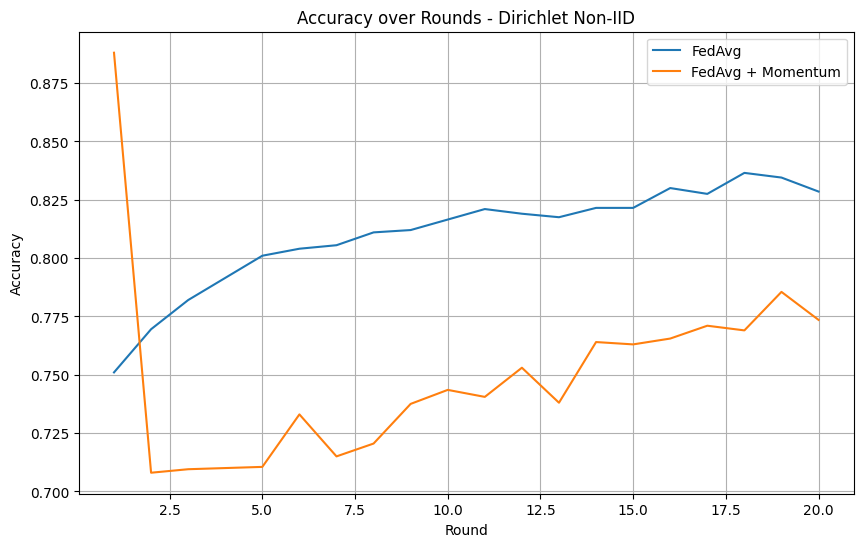

In [4]:
# Create TFF dataset
dirichlet_clients = cf.create_dirichlet_non_iid(df_final, num_clients=5, alpha=0.5, label_col='Maintenance_required')
# Compare on Dirichlet Non-IID data
cf.compare_algorithms(dirichlet_clients, "Dirichlet Non-IID", num_rounds=20)

# Step 5: Create Feature Skew Non-IID Client Partition and run comparisons for FedAvg and FedAvg with Momentum

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Round 1: Accuracy=0.4830
Round 2: Accuracy=0.6390
Round 3: Accuracy=0.6640
Round 4: Accuracy=0.6750
Round 5: Accuracy=0.6775
Round 6: Accuracy=0.6860
Round 7: Accuracy=0.6890
Round 8: Accuracy=0.6940
Round 9: Accuracy=0.6930
Round 10: Accuracy=0.7005
Round 11: Accuracy=0.6995
Round 12: Accuracy=0.7045
Round 13: Accuracy=0.7080
Round 14: Accuracy=0.7230
Round 15: Accuracy=0.7245
Round 16: Accuracy=0.7260
Round 17: Accuracy=0.7310
Round 18: Accuracy=0.7340
Round 19: Accuracy=0.7390
Round 20: Accuracy=0.7415
Round 1: Accuracy=0.6150
Round 2: Accuracy=0.6765
Round 3: Accuracy=0.6980
Round 4: Accuracy=0.7200
Round 5: Accuracy=0.7365
Round 6: Accuracy=0.7395
Round 7: Accuracy=0.7510
Round 8: Accuracy=0.7595
Round 9: Accuracy=0.7635
Round 10: Accuracy=0.7640
Round 11: Accuracy=0.7720
Round 12: Accuracy=0.7870
Round 13: Accuracy=0.7830
Round 14: Accuracy=0.7920
Round 15: Accuracy=0.7815
Round 16: Accuracy=0.7955
Round 17: Accuracy=0.7830
Round 18: Accuracy=0.8030
Round 19: Accuracy=0.8025
Roun

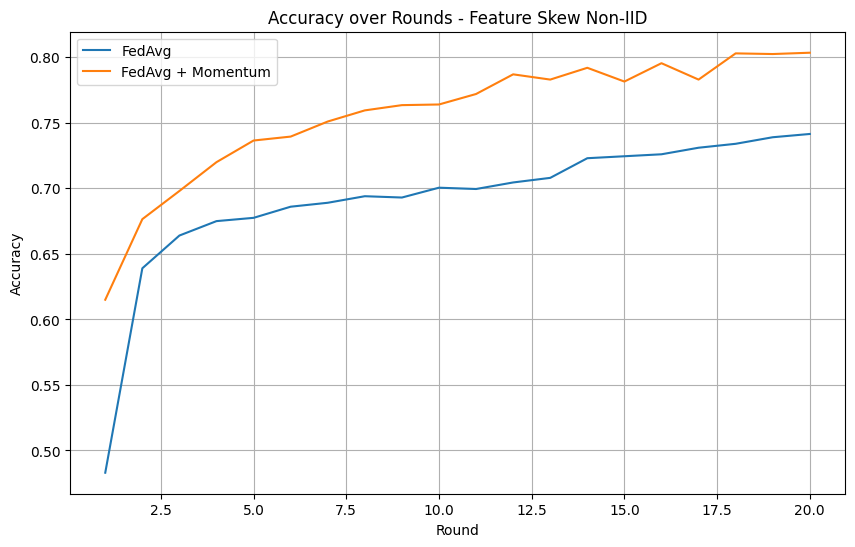

In [5]:
# Create IID dataset
feature_skew_clients = cf.create_feature_skew_non_iid(df_final, num_clients=5, feature='SF6_density', label_col='Maintenance_required')
# Compare on Feature Skew Non-IID data
cf.compare_algorithms(feature_skew_clients, "Feature Skew Non-IID", num_rounds=20)

# Step 6: Compare All Four Federated Algorithms

Instructions for updating:
Colocations handled automatically by placer.
/usr/local/lib/python3.11/dist-packages/tensorflow_federated/python/learning/models/keras_utils.py:201: UserWarning: Batch Normalization contains non-trainable variables that won't be updated during the training. Consider using Group Normalization instead.
  warnings.warn(


Round 1: Accuracy=0.4810
Round 2: Accuracy=0.6675
Round 3: Accuracy=0.6765
Round 4: Accuracy=0.6840
Round 5: Accuracy=0.6870
Round 6: Accuracy=0.6935
Round 7: Accuracy=0.6950
Round 8: Accuracy=0.6965
Round 9: Accuracy=0.6950
Round 10: Accuracy=0.6985
Round 11: Accuracy=0.6985
Round 12: Accuracy=0.7005
Round 13: Accuracy=0.7050
Round 14: Accuracy=0.7110
Round 15: Accuracy=0.7150
Round 16: Accuracy=0.7150
Round 17: Accuracy=0.7205
Round 18: Accuracy=0.7280
Round 19: Accuracy=0.7255
Round 20: Accuracy=0.7370
Round 1: Accuracy=0.6610
Round 2: Accuracy=0.6970
Round 3: Accuracy=0.7180
Round 4: Accuracy=0.7325
Round 5: Accuracy=0.7550
Round 6: Accuracy=0.7570
Round 7: Accuracy=0.7700
Round 8: Accuracy=0.7705
Round 9: Accuracy=0.7850
Round 10: Accuracy=0.7805
Round 11: Accuracy=0.7915
Round 12: Accuracy=0.7950
Round 13: Accuracy=0.7960
Round 14: Accuracy=0.7990
Round 15: Accuracy=0.8005
Round 16: Accuracy=0.8020
Round 17: Accuracy=0.8130
Round 18: Accuracy=0.8090
Round 19: Accuracy=0.8115
Roun

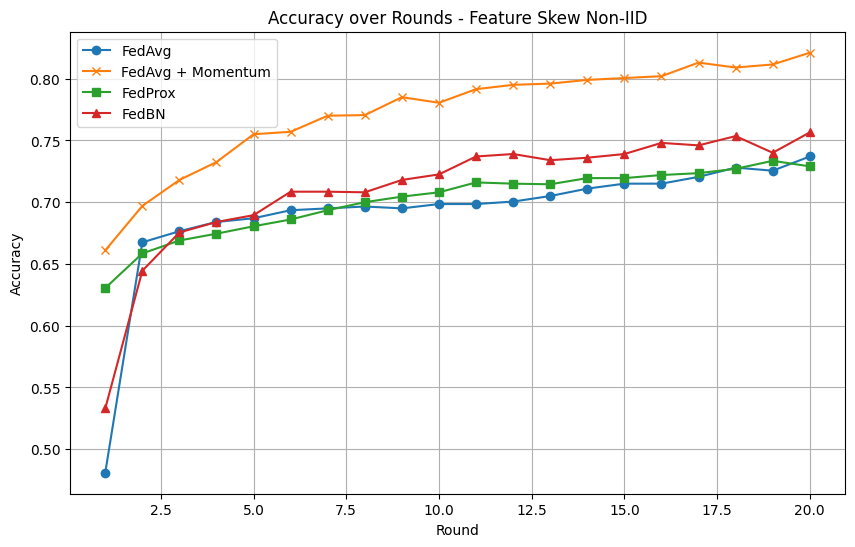

In [6]:
# For Feature Skew Non-IID data, we can also compare all algorithms
# using the compare_all_algorithms function
cf.compare_all_algorithms(feature_skew_clients, "Feature Skew Non-IID", num_rounds=20)